In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
token_latency = pd.read_csv("iter_level/new_iter_result_scheduling_policy_swap_policy.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'iter_level/iter_result_scheduling_policy_swap_policy.csv'

In [27]:
token_latency['TP']=token_latency['num_tokens']/token_latency["latency"]
token_prefill_time = (
    token_latency[(token_latency["current_stage"] == "hybrid")][
        ["policy", "latency", "repeat_time", "batch_size","TP"]
    ]
    .groupby(["policy", "repeat_time", "batch_size"])
    .agg(
         latency=("latency", "sum"),
         TP=("TP", "mean"),
     )
    .reset_index()
)


# max_prefill_time_index = token_prefill_time.groupby(["policy"])["latency"].idxmax()

# token_prefill_time = token_prefill_time.drop(max_prefill_time_index)
# token_prefill_time = token_prefill_time[token_prefill_time["repeat_time"] <7]

In [28]:
token_prefill_time[token_prefill_time["repeat_time"]==0]

,policy,repeat_time,batch_size,latency,TP
0,fcfs,0,32,0.316275,5040.950118
1,fcfs,0,64,0.426357,4298.324183
2,fcfs,0,128,0.408536,4745.016254
60,lrf,0,32,0.307839,5678.094040
61,lrf,0,64,0.310188,5785.759340
62,lrf,0,128,0.347106,5570.087141
120,stf,0,32,0.326333,4415.263597
121,stf,0,64,0.364537,4513.207308
122,stf,0,128,0.391487,4935.367322


In [36]:
scheduling_policy_result = (
    token_prefill_time.groupby(["policy", "batch_size"]).mean().reset_index()
)
for bs in scheduling_policy_result["batch_size"].unique():
    scheduling_policy_result.loc[
        scheduling_policy_result["batch_size"] == bs, "latency_diff_ratio"
    ] = (
        (
            scheduling_policy_result.loc[
                scheduling_policy_result["batch_size"] == bs, "latency"
            ]
        )
    ) / scheduling_policy_result.loc[
        scheduling_policy_result["batch_size"] == bs, "latency"
    ].min()
    scheduling_policy_result.loc[
        scheduling_policy_result["batch_size"] == bs, "throughput_diff_ratio"
    ] = (
        (
            scheduling_policy_result.loc[
                scheduling_policy_result["batch_size"] == bs, "TP"
            ]
        )
    ) / scheduling_policy_result.loc[
        scheduling_policy_result["batch_size"] == bs, "TP"
    ].min()

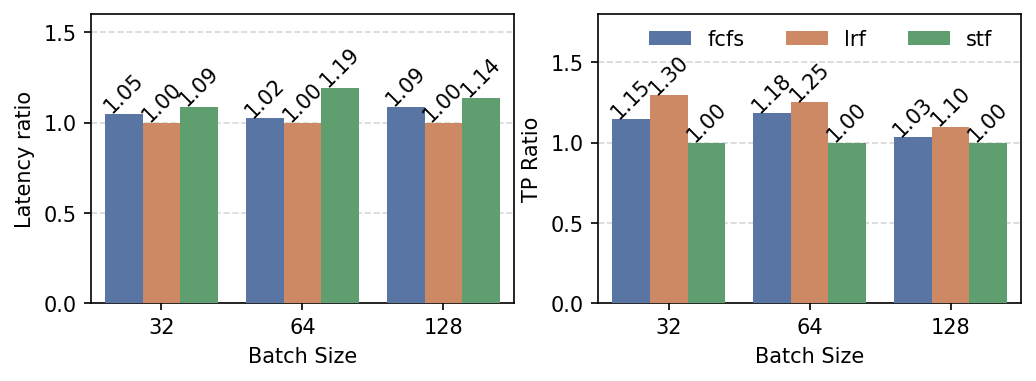

In [65]:
fig,axes = plt.subplots(1,2,figsize=(8,2.5),dpi=150)
sns.color_palette("deep")
sns.barplot(
    hue="policy",
    y="latency_diff_ratio",
    x="batch_size",
    palette="deep",
    data=scheduling_policy_result,
    ax=axes[0],
    zorder=3,
    legend=False
)
sns.barplot(
    hue="policy",
    y="throughput_diff_ratio",
    x="batch_size",
    palette="deep",
    data=scheduling_policy_result,
    zorder=3,
    ax=axes[1]
)
for p in axes[0].patches:
    if p.get_height() == 0:
        continue
    axes[0].annotate(
        format(p.get_height(), ".2f"),
        (p.get_x() + p.get_width() / 2.0, p.get_height() * 1),
        ha="center",
        va="center",
        xytext=(0, 10),
        rotation=45,
        textcoords="offset points",
    )
for p in axes[1].patches:
    if p.get_height() == 0:
        continue
    axes[1].annotate(
        format(p.get_height(), ".2f"),
        (p.get_x() + p.get_width() / 2.0, p.get_height() * 1),
        ha="center",
        va="center",
        xytext=(0, 10),
        rotation=45,
        textcoords="offset points",
    )
axes[0].grid(alpha=0.5,linestyle='--',axis='y',zorder=0)
axes[1].grid(alpha=0.5,linestyle='--',axis='y',zorder=0)
axes[1].legend(ncols=3, frameon=False, loc=(0.1, 0.85))
axes[0].set_ylim(0, 1.6)
axes[1].set_ylim(0,1.8)
axes[0].set_ylabel("Latency ratio")
axes[1].set_ylabel("TP Ratio")
axes[0].set_xlabel("Batch Size")
axes[1].set_xlabel("Batch Size")
plt.xticks(rotation=0)
plt.show()

# request level  analysis

In [66]:
request_level_result = pd.read_csv(
    "request_level/new_request_result_scheduling_policy_swap_fcfs.csv"
)
request_level_result = request_level_result[request_level_result["prompt_length"] > 2]

In [67]:
request_level_result["latency"] = (
    request_level_result["request_end_time"]
    - request_level_result["request_start_time"]
)

In [68]:
request_level_latency_result = (
    request_level_result[
        ["policy", "latency", "request_id", "prompt_length", "batch_size"]
    ]
    .groupby(["policy", "request_id", "prompt_length", "batch_size"])
    .mean()
    .reset_index()
)

In [69]:
request_avg_e2e_latency = (
    request_level_latency_result[["policy", "latency", "batch_size"]]
    .groupby(["policy", "batch_size"])
    .mean()
    .reset_index()
)

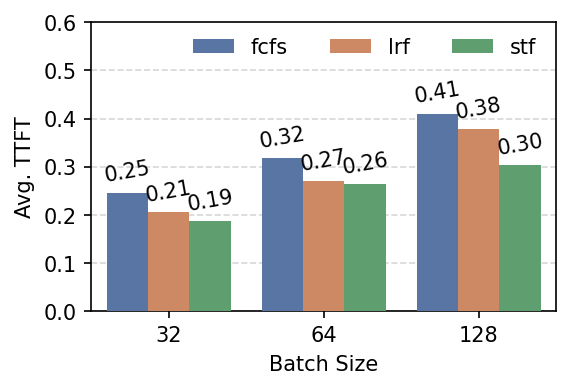

In [77]:
plt.figure(figsize=(4, 2.5), dpi=150)
sns.color_palette("deep")
ax=sns.barplot(
    hue="policy",
    y="latency",
    x="batch_size",
    palette="deep",
    data=request_avg_e2e_latency,
    zorder=3,
)
for p in ax.patches:
    if p.get_height() == 0:
        continue
    ax.annotate(
        format(p.get_height(), ".2f"),
        (p.get_x() + p.get_width() / 2.0, p.get_height() * 1),
        ha="center",
        va="center",
        xytext=(0, 10),
        rotation=10,
        textcoords="offset points",
    )
plt.legend(ncol=3, frameon=False, loc=(0.2, 0.85))
plt.ylabel("Avg. TTFT")
plt.xlabel("Batch Size")
plt.ylim(0,0.6)
plt.xticks(rotation=0)
plt.grid(alpha=0.5,zorder=1,linestyle="--",axis='y')
plt.show()